In [1]:
# Подгрузим необходимые для работы библиотеки
import glob
import numpy as np 
import pandas as pd 
import scipy
import copy
from random import *
from scipy import signal, fftpack
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from mpl_toolkits.mplot3d import Axes3D
from random import random
from numpy import array
from numpy import cumsum
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
import seaborn as sns
%matplotlib inline
with pd.option_context("display.max_rows", 10, "display.max_columns", 20):
    print(pd.get_option("display.max_rows")) 
    print(pd.get_option("display.max_columns"))
FN = 1

Using TensorFlow backend.
/home/jurgen/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jurgen/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jurgen/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jurgen/py_36_env/lib/python3.6/site-packages/tenso

10
20


/home/jurgen/py_36_env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jurgen/py_36_env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jurgen/py_36_env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jurgen/py_36_env/lib/python3.6/site-packages/tensorboar

# Класс для хранения информации о результатах контроля

In [4]:
class SOP:
    control_results = None
    smoothed_control_results = None
    hord_shift = 145
    pc_shift = 50 
    pc_schemes = [3,4,5,6,9,10]
    hord_schemes = [1,2,7,8,11,12,13,14,15,16]
    transverse_defects_columns = [7,8,15,16]
    longitudinal_defects_set = None # Список тактов отслеживающих продольные дефекты
    transverse_defects_set = None # Список тактов отслеживающих поперечные дефекты
    
    def __init__(self, filepath="SOP1.txt"):
        self.filepath = filepath
        
    def read_control_results(self):
        # В рамках текущего модуля пока избавимся от первого столбца с номерами измерений, пока в них нет необходимости
        splited_info = ""
        with open(self.filepath, mode="r", encoding="cp1251") as f:
            splited_info = f.readline()
        self.control_results=pd.read_csv(self.filepath, encoding="cp1251", delimiter = " ", header = None, skiprows = 1)
        self.control_results = self.control_results.drop(columns=[0])
        print(self.control_results.shape[0])
        splited_info = splited_info.split(' ')
        self.date = splited_info[1]
        self.time = splited_info[2]
        self.temperature = splited_info[3]
        
    def fix_shift_issue(self):
        self.control_results = self.control_results.iloc[:1024]
        self.smoothed_control_results = self.smoothed_control_results.iloc[:1024]
        for scheme in self.pc_schemes:
            self.control_results[scheme] = np.roll(self.control_results[scheme], -self.pc_shift)
            self.smoothed_control_results[scheme] = np.roll(self.smoothed_control_results[scheme], -self.pc_shift)
        
        for scheme in self.hord_schemes:
            self.control_results[scheme] = np.roll(self.control_results[scheme], -self.hord_shift)
            self.smoothed_control_results[scheme] = np.roll(self.smoothed_control_results[scheme], -self.hord_shift)
    
    def smooth_control_results(self):
        self.smoothed_control_results = copy.deepcopy(self.control_results)
        for cont_res in self.control_results:
            self.smoothed_control_results[cont_res] = savgol_filter(self.control_results[cont_res], 15, 3)
    
    def split_by_defects(self):
        self.longitudinal_defects_set = self.smoothed_control_results.drop(self.transverse_defects_columns, axis=1)
        self.transverse_defects_set = self.smoothed_control_results[self.transverse_defects_columns]
        
    def load_target_variable(self, filepath):
        target = pd.read_csv(filepath)
        self.longitudinal_defects_set['y'] = 0
        self.transverse_defects_set['y_t'] = 0
        # Fill l defect
        for index, row in target[target['Тип дефекта'] == "L"].iterrows():
            self.longitudinal_defects_set["y"][int(row["Начало дефекта"]):int(row["Начало дефекта"]) + int(row["Длина дефекта"])] = 1

        for index, row in target[target['Тип дефекта'] == "T"].iterrows():
            self.transverse_defects_set["y_t"][int(row["Начало дефекта"]):15 + int(row["Начало дефекта"])] = 1
             

### Загрузка тренировочной выборки

In [5]:
sop_list = []
sop_files = glob.glob("*.dat")
for file_path in sop_files:
    print(file_path)
    sop_list.append(SOP(file_path))

for sop in sop_list:
    sop.read_control_results()
    sop.smooth_control_results()
    sop.fix_shift_issue()
    sop.split_by_defects()

sop_list[0].load_target_variable("target/target1.csv")
sop_list[1].load_target_variable("target/target2.csv")
sop_list[2].load_target_variable("target/target3.csv")

К3_test.dat
SOP3.dat
SOP1.dat
К28_test.dat
К16_test.dat
SOP2.dat
d5.dat
К24_test.dat
К22_test.dat
1028
1038
1042
1019
1037
1039
1034
1033
1024


/home/jurgen/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jurgen/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jurgen/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jurgen/py_36_env

### Загрузка тестовой(контрольной) выборки

In [6]:
test_sop_list = []
sop_files = glob.glob("Results/*test.dat")
for file_path in sop_files:
    print(file_path)
    test_sop_list.append(SOP(file_path))

for sop in test_sop_list:
    sop.read_control_results()
    sop.smooth_control_results()
    sop.fix_shift_issue()
    sop.split_by_defects()

# target_files = glob.glob("Target_/*test.csv")
# for idx, file_path in enumerate(target_files):
#     print(file_path)
#     test_sop_list[idx].load_target_variable(file_path)


    
# test_sop_list[0]
# sop_list[0].load_target_variable("Target/k3_test.csv")
# sop_list[1].load_target_variable("target/target1.csv")
# sop_list[2].load_target_variable("target/target1.csv")

Results/К3_test.dat
Results/К28_test.dat
Results/К16_test.dat
Results/К24_test.dat
Results/К22_test.dat
1028
1019
1037
1033
1024


In [7]:
test_sop_list[0].load_target_variable("Target_/k16_test.csv")
test_sop_list[1].load_target_variable("Target_/k22_test.csv")
test_sop_list[2].load_target_variable("Target_/k3_test.csv")
test_sop_list[3].load_target_variable("Target_/k28_test.csv")
test_sop_list[4].load_target_variable("Target_/k24_test.csv")

/home/jurgen/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jurgen/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jurgen/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jurgen/py_36_env

# РАЗБИЕНИЕ ДАННЫХ НА ОБУЧАЮЩУЮ И ПРОВЕРОЧНУЮ ВЫБОРКУ

Для разбиения данных на тренировочную и тестовую выборку воспользуемся пакетом sklearn, и специальным методо перекрестной оценки, так как набор данных в в тестовой и контрольной выборке не слишком велик, то придется прибегать к методам не допускающим переобучения модели и позволяющих использовать весь доступный набор данных. Алгоритм в качестве примера представлен ниже, далее при обучении модели мы будем использовать именно его 

# !!! ПРИМЕР

In [18]:
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit(n_splits=5)
print(tscv)  +

for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Процесс обучения модели      
    


TimeSeriesSplit(max_train_size=None, n_splits=5)
TRAIN: [0] TEST: [1]
TRAIN: [0 1] TEST: [2]
TRAIN: [0 1 2] TEST: [3]
TRAIN: [0 1 2 3] TEST: [4]
TRAIN: [0 1 2 3 4] TEST: [5]


# ОБУЧЕНИЕ МОДЕЛИ И ПРОВЕРКА ТОЧНОСТИ НА ПУБЛИЧНОЙ КОНТРОЛЬНОЙ ВЫБОРКЕ

Далее перейдем к построению модели и вытащим значения из класса, Приведем данный в формат который мы сможем использовать при обучении модели, Первой моделью будет двунапраленная рекурентная сеть

### Модель для продольных дефектов

# Формирование набора данных для входа модели. Код создающий требуемый набор данных

Объединим данные из исходной и тренировочной выборки. Оставив только два набора К24 и к28 в качестве итоговой проверочной выборки, получив низкую разность на тренировочной точности и обучающей. Вышеуказанымми наборами мы дообучим нашу модель 

In [8]:
train_data = sop_list[0].longitudinal_defects_set.drop(columns=["y"],axis=1)
train_labels = sop_list[0].longitudinal_defects_set['y']

train_data1 = sop_list[1].longitudinal_defects_set.drop(columns=["y"],axis=1)
train_labels1 = sop_list[1].longitudinal_defects_set['y']

train_data2 = sop_list[2].longitudinal_defects_set.drop(columns=["y"],axis=1)
train_labels2 = sop_list[2].longitudinal_defects_set['y']

train_data3 = test_sop_list[0].longitudinal_defects_set.drop(columns=["y"],axis=1)
train_labels3 = sop_list[0].longitudinal_defects_set['y']

train_data4 = test_sop_list[1].longitudinal_defects_set.drop(columns=["y"],axis=1)
train_labels4 = sop_list[1].longitudinal_defects_set['y']

train_data5 = test_sop_list[2].longitudinal_defects_set.drop(columns=["y"],axis=1)
train_labels5 = sop_list[2].longitudinal_defects_set['y']

train_X = pd.concat([train_data, train_data1, train_data2, train_data3, train_data4, train_data5], ignore_index=True)
train_Y = pd.concat([train_labels, train_labels1, train_labels2,train_labels3, train_labels4, train_labels5 ], ignore_index=True)

In [10]:
train_X = np.array(train_X)
train_X = train_X.reshape(6,1024,12)
train_Y = np.array(train_Y)
train_Y = train_Y.reshape(6,1024,1)
print(train_X.shape)
print(train_Y.shape)

ValueError: cannot reshape array of size 73668 into shape (6,1024,12)

### Реккурентная нейронная сеть

In [3]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import GRU, LSTM
from keras.layers import Bidirectional, Dense
from keras.models import Sequential

In [4]:
# model = Sequential()
# model.add(Bidirectional(LSTM(16, input_shape=(1024, 12), return_sequences=True)))
# model.add(Bidirectional(LSTM(16, return_sequences=True)))
# model.add(GRU(1, activation="sigmoid", return_sequences=True)) 
# model.compile(loss="binary_crossentropy", optimizer="Adam",  metrics=['accuracy'])


оценка точности модели на обучающей выборке

In [9]:
from keras.layers import Input, Dense, LSTM, MaxPooling1D, Conv1D
from keras.models import Model
model = Sequential()
input_layer = Input(shape=(1024, 12))
conv1 = Conv1D(filters=32,
               kernel_size=8,
               strides=1,
               activation='relu',
               padding='same')(input_layer)
conv2 = Conv1D(filters=32,
               kernel_size=4,
               strides=1,
               activation='relu',
               padding='same')(conv1)
# lstm1 = Bidirectional(LSTM(16,return_sequences=True))(conv1)
output_layer = GRU(1, activation="sigmoid", return_sequences=True)(conv2)
model = Model(inputs=input_layer, outputs=output_layer)
# model.add(Bidirectional(LSTM(16, input_shape=(1024, 12), return_sequences=True)))
# model.add(Bidirectional(LSTM(16, return_sequences=True)))
# model.add(GRU(1, activation="sigmoid", return_sequences=True)) 
model.compile(loss="binary_crossentropy", optimizer="Adam",  metrics=['accuracy'])


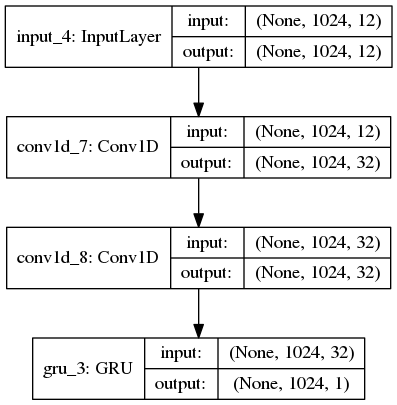

In [10]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [81]:

tscv = TimeSeriesSplit(n_splits=4)
print(tscv)  

for train_index, test_index in tscv.split(train_X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = train_X[train_index], train_X[test_index]
    y_train, y_test = train_Y[train_index], train_Y[test_index]
    model.fit(X_train, y_train, epochs=10, batch_size=1)
    model.evaluate(X_test, y_test, verbose=1)
    scores = model.evaluate(X_test, y_test, verbose=1)
    print('binary_crossentropy=%f, accuracy=%f' % (scores[0],scores[1]))
    
# , validation_split=0.2

TimeSeriesSplit(max_train_size=None, n_splits=4)
TRAIN: [0 1] TEST: [2]
Epoch 1/10
2/2 [==============================] - 3s 2s/step - loss: 0.7450 - acc: 0.5210
Epoch 2/10
2/2 [==============================] - 1s 513ms/step - loss: 0.6017 - acc: 0.6743
Epoch 3/10
2/2 [==============================] - 1s 514ms/step - loss: 0.5041 - acc: 0.7974
Epoch 4/10
2/2 [==============================] - 1s 513ms/step - loss: 0.4509 - acc: 0.8730
Epoch 5/10
2/2 [==============================] - 1s 511ms/step - loss: 0.4183 - acc: 0.8999
Epoch 6/10
2/2 [==============================] - 1s 512ms/step - loss: 0.3970 - acc: 0.9062
Epoch 7/10
2/2 [==============================] - 1s 508ms/step - loss: 0.3667 - acc: 0.9160
Epoch 8/10
2/2 [==============================] - 1s 512ms/step - loss: 0.3477 - acc: 0.9121
Epoch 9/10
2/2 [==============================] - 1s 508ms/step - loss: 0.3305 - acc: 0.9209
Epoch 10/10
1/1 [==============================] - 0s 95ms/step
binary_crossentropy=0.441411, 

In [84]:
X_train = train_X[5]
y_train = train_Y[5]
X_train = X_train.reshape(1,1024,12)
y_train = y_train.reshape(1,1024,1)
model.fit(X_train, y_train, epochs=10, batch_size=1)


Epoch 1/10
1/1 [==============================] - 1s 550ms/step - loss: 0.6003 - acc: 0.7266
Epoch 2/10
1/1 [==============================] - 1s 527ms/step - loss: 0.5926 - acc: 0.7275
Epoch 3/10
1/1 [==============================] - 1s 525ms/step - loss: 0.5773 - acc: 0.7314
Epoch 4/10
1/1 [==============================] - 1s 516ms/step - loss: 0.5661 - acc: 0.7314
Epoch 5/10
1/1 [==============================] - 1s 519ms/step - loss: 0.5550 - acc: 0.7354
Epoch 6/10
1/1 [==============================] - 1s 525ms/step - loss: 0.5504 - acc: 0.7383
Epoch 7/10
1/1 [==============================] - 1s 522ms/step - loss: 0.5459 - acc: 0.7451
Epoch 8/10
1/1 [==============================] - 1s 517ms/step - loss: 0.5408 - acc: 0.7490
Epoch 9/10
1/1 [==============================] - 1s 521ms/step - loss: 0.5365 - acc: 0.7520
Epoch 10/10
1/1 [==============================] - 1s 531ms/step - loss: 0.5329 - acc: 0.7520


Построим боксплот для оценки пограничных значений после предсказания  

6/6 [==============================] - 1s 130ms/step


{'whiskers': [<matplotlib.lines.Line2D at 0x7ff83263d4a8>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff83263db38>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff83263d198>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff8325c7208>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff8325c7550>],
 'means': []}

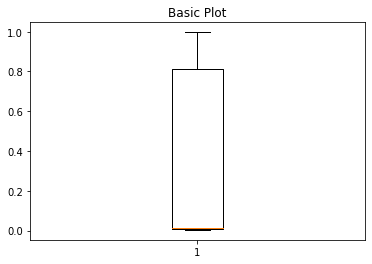

In [60]:
train_prediction = model.predict(train_X, verbose=1)
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(train_prediction[0])

Данный график поможет нам совместить модели для продольных и поперечных значений. И по результатам обоих моделей выносить конкретное решение о наличие того или иного дефекта в данных

### Оценим модель на оставшихся тестовых  данных к28 и на данных обучающей выборки  

In [61]:
test_data1 = test_sop_list[3].longitudinal_defects_set.drop(columns=["y"],axis=1)
test_labels1 = test_sop_list[3].longitudinal_defects_set['y']

test_data2 = test_sop_list[4].longitudinal_defects_set.drop(columns=["y"],axis=1)
test_labels2 = test_sop_list[4].longitudinal_defects_set['y']

test_X = pd.concat([test_data2, ], ignore_index=True)
test_Y = pd.concat([test_labels2], ignore_index=True)
print(test_X.shape)
print(test_Y.shape)

test_X = np.array(test_X)
test_X = test_X.reshape(1,1024,12)
test_Y = np.array(test_Y)
test_Y = test_Y.reshape(1,1024,1)

(1024, 12)
(1024,)


Двунаправленная нейронная сеть не сильно отличается по точности от однонаправленной, однако имеет меньшее точности и потерь на тестовом и обучающем наборе данных 

### Итоговая оценка точности модели для продольных дефектов первое loss, второе Accuracy

In [62]:
train_evaluation = model.evaluate(train_X, train_Y, verbose=1)
print(train_evaluation)
test_evaluation = model.evaluate(test_X, test_Y, verbose=1)
print(test_evaluation)

6/6 [==============================] - 0s 28ms/step
[0.27934062480926514, 0.87451171875]
1/1 [==============================] - 0s 138ms/step
[0.23103740811347961, 0.9306640625]


In [85]:
# serialize model to JSON
model_json = model.to_json()
with open("model_L.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_L.h5")
print("Saved model to disk")

Saved model to disk


# Модель поперечных дефектов, выполним полностью аналогично модели для продольных дефектов

In [37]:
T_train_data = sop_list[0].transverse_defects_set.drop(columns=[ "y_t"],axis=1)
T_train_labels = sop_list[0].transverse_defects_set['y_t']

T_train_data1 = sop_list[1].transverse_defects_set.drop(columns=["y_t"],axis=1)
T_train_labels1 = sop_list[1].transverse_defects_set['y_t']

T_train_data2 = sop_list[2].transverse_defects_set.drop(columns=[ "y_t"],axis=1)
T_train_labels2 = sop_list[2].transverse_defects_set['y_t']

T_train_data3 = test_sop_list[0].transverse_defects_set.drop(columns=["y_t"],axis=1)
T_train_labels3 = sop_list[0].transverse_defects_set['y_t']

T_train_data4 = test_sop_list[1].transverse_defects_set.drop(columns=["y_t"],axis=1)
T_train_labels4 = sop_list[1].transverse_defects_set['y_t']

T_train_data5 = test_sop_list[2].transverse_defects_set.drop(columns=["y_t"],axis=1)
T_train_labels5 = sop_list[2].transverse_defects_set['y_t']

T_train_X = pd.concat([T_train_data, T_train_data1, T_train_data2, T_train_data3, T_train_data4, T_train_data5], ignore_index=True)
T_train_Y = pd.concat([T_train_labels, T_train_labels1, T_train_labels2,T_train_labels3, T_train_labels4, T_train_labels5 ], ignore_index=True)

T_train_X = np.array(T_train_X)
T_train_X = T_train_X.reshape(6,1024,4)
T_train_Y = np.array(T_train_Y)
T_train_Y = T_train_Y.reshape(6,1024,1)
print(T_train_X.shape)
print(T_train_Y.shape)

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import GRU, LSTM
from keras.layers import Bidirectional, Dense
from keras.models import Sequential


T_model = Sequential()
T_model.add(GRU(16, input_shape=(1024, 4), return_sequences=True)) 
T_model.add(GRU(1, activation="sigmoid", return_sequences=True)) 
T_model.compile(loss="binary_crossentropy", optimizer="Adam",  metrics=['accuracy'])

tscv = TimeSeriesSplit(n_splits=4)
print(tscv)  

for train_index, test_index in tscv.split(T_train_X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = T_train_X[train_index], T_train_X[test_index]
    y_train, y_test = T_train_Y[train_index], T_train_Y[test_index]
    T_model.fit(X_train, y_train, epochs=10, batch_size=1)
#     T_model.evaluate(X_test, y_test, verbose=1)
    scores = T_model.evaluate(X_test, y_test, verbose=1)
    print('binary_crossentropy=%f, accuracy=%f' % (scores[0],scores[1]))
    
# , validation_split=0.2

(6, 1024, 4)
(6, 1024, 1)
TimeSeriesSplit(max_train_size=None, n_splits=4)
TRAIN: [0 1] TEST: [2]
Epoch 1/10
2/2 [==============================] - 2s 952ms/step - loss: 0.3752 - acc: 0.9702
Epoch 2/10
2/2 [==============================] - 1s 628ms/step - loss: 0.3572 - acc: 0.9707
Epoch 3/10
2/2 [==============================] - 1s 652ms/step - loss: 0.3406 - acc: 0.9780
Epoch 4/10
2/2 [==============================] - 1s 547ms/step - loss: 0.3245 - acc: 0.9780
Epoch 5/10
2/2 [==============================] - 1s 470ms/step - loss: 0.3092 - acc: 0.9785
Epoch 6/10
2/2 [==============================] - 1s 467ms/step - loss: 0.2944 - acc: 0.9790
Epoch 7/10
2/2 [==============================] - 1s 470ms/step - loss: 0.2809 - acc: 0.9795
Epoch 8/10
2/2 [==============================] - 1s 546ms/step - loss: 0.2684 - acc: 0.9795
Epoch 9/10
2/2 [==============================] - 1s 547ms/step - loss: 0.2561 - acc: 0.9795
Epoch 10/10
1/1 [==============================] - 0s 300ms/step


6/6 [==============================] - 0s 54ms/step


{'whiskers': [<matplotlib.lines.Line2D at 0x7f8549c0f278>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8549c0f978>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8549c0f128>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8549c17048>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8549c17390>],
 'means': []}

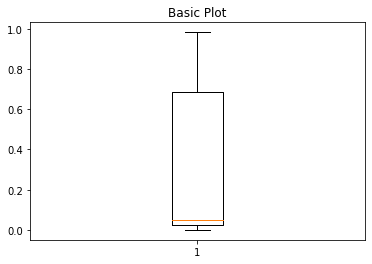

In [39]:
T_train_prediction = T_model.predict(T_train_X, verbose=1)
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(train_prediction[0])

In [40]:
test_data1 = test_sop_list[3].transverse_defects_set.drop(columns=["y_t"],axis=1)
test_labels1 = test_sop_list[3].transverse_defects_set['y_t']

test_data2 = test_sop_list[4].transverse_defects_set.drop(columns=["y_t"],axis=1)
test_labels2 = test_sop_list[4].transverse_defects_set['y_t']

test_X = pd.concat([test_data2, ], ignore_index=True)
test_Y = pd.concat([test_labels2], ignore_index=True)
print(test_X.shape)
print(test_Y.shape)

test_X = np.array(test_X)
test_X = test_X.reshape(1,1024,4)
test_Y = np.array(test_Y)
test_Y = test_Y.reshape(1,1024,1)

(1024, 4)
(1024,)


{'whiskers': [<matplotlib.lines.Line2D at 0x7f854af85588>,
 'caps': [<matplotlib.lines.Line2D at 0x7f854af7ec50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f854af850f0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f854af7e198>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f854af7e208>],
 'means': []}

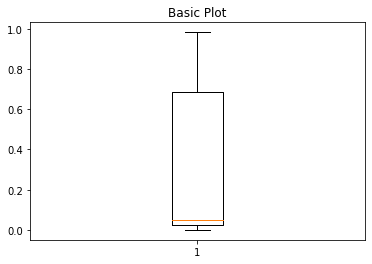

In [41]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(train_prediction[0])

### Итоговая оценка точности модели для поперечных дефектов первое loss, второе Accuracy

In [42]:
train_evaluation = T_model.evaluate(T_train_X, T_train_Y, verbose=1)
print(train_evaluation)
test_evaluation = T_model.evaluate(test_X, test_Y, verbose=1)
print(test_evaluation)

6/6 [==============================] - 0s 16ms/step
[0.08258680999279022, 0.9845377802848816]
1/1 [==============================] - 0s 82ms/step
[0.192806214094162, 0.9560546875]


Какие мы можем сделать выводы из каждой модели, точность можно считать релевантной, так как разница между обучающей выборкой и тестовой выборкой практически минимальны, чтобы понять примерную картину по тому как влияют переменные на конечный резульата построим график по столбцам данных совместно с предсказанием модели на котором расположим предсказания по каждому из типов дефекта 

In [43]:
T_train_prediction = T_model.predict(T_train_X, verbose=1)
T_train_prediction = T_train_prediction.reshape(1024*6)

6/6 [==============================] - 0s 18ms/step


In [44]:
train_prediction = model.predict(train_X, verbose=1)
train_prediction = train_prediction.reshape(1024*6)

6/6 [==============================] - 0s 20ms/step


In [46]:
# serialize model to JSON
model_json = model.to_json()
with open("model_T.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_T.h5")
print("Saved model to disk")

Saved model to disk


# ВИЗУАЛЬНОЕ ОБОСНОВАНИЕ ВЫБОРА ПЕРЕМЕННЫХ/ РАБОТОСПОСОБНОСТИ МОДЕЛИ

# Финальная оценка 

In [98]:
from keras.models import model_from_json

In [117]:
sop = SOP("К24_test.dat")
sop.read_control_results()
sop.smooth_control_results()
sop.fix_shift_issue()
sop.split_by_defects()
sop.load_target_variable("Target_/k24_test.csv")

# ready long defects
X_L = np.array(sop.longitudinal_defects_set.drop(columns=["y"],axis=1))
X_L = X_L.reshape(1, 1024, 12)
# X_T = np.array(sop.transverse_defects_set)
# X_T = X_T.reshape(1, 1024, 4)

1033


/home/competitor2/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/competitor2/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/competitor2/.local/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/competitor2/.local/lib/python3.6/site-packages/ipykernel_l

In [118]:
json_file = open('model_L.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_longitudinal = model_from_json(loaded_model_json)
# load weights into new model
model_longitudinal.load_weights("model_L.h5")
print("Loaded TRANSVERS model from disk")
longitudinal_prediction = model_longitudinal.predict(X_L, verbose=1)

Loaded TRANSVERS model from disk
1/1 [==============================] - 1s 953ms/step


In [119]:
visualize_prediction = longitudinal_prediction.reshape(1024,1)

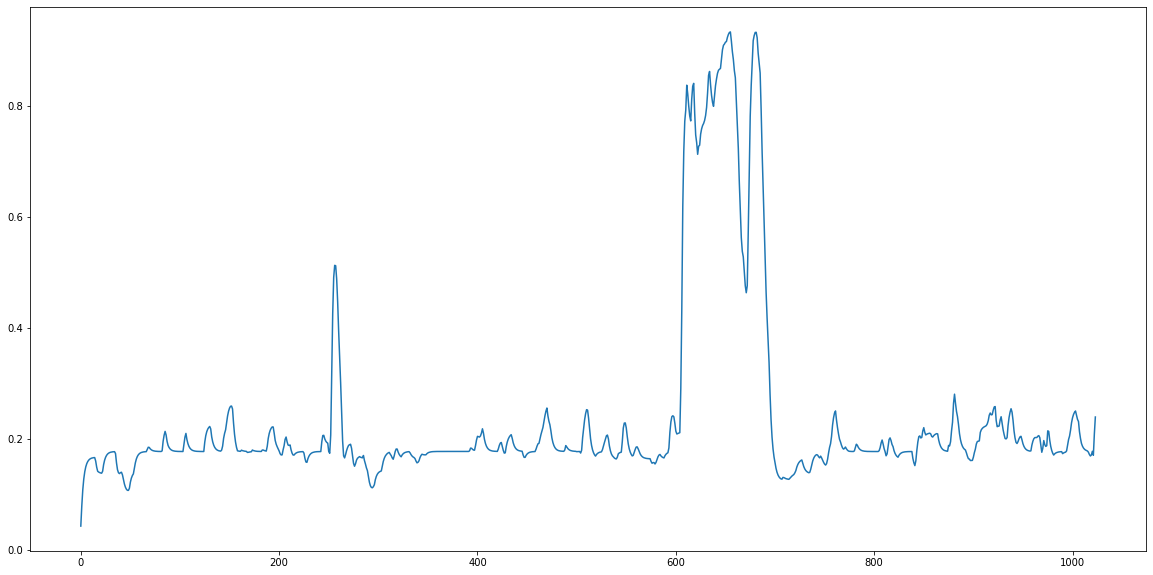

In [120]:
plt.figure(figsize=(20,10))
plt.plot(visualize_prediction)
plt.plot()
plt.show()

In [121]:
longitudinal_prediction = longitudinal_prediction > 0.38
longitudinal_prediction = longitudinal_prediction.astype(int)
longitudinal_prediction = longitudinal_prediction.reshape(longitudinal_prediction.shape[1])

In [122]:
for idx,value in enumerate(longitudinal_prediction):
    if value == 1:
        longitudinal_prediction[idx] = 100
        
sop.longitudinal_defects_set.loc[sop.longitudinal_defects_set["y"] == 1, 'y'] = 50

In [123]:
sop.longitudinal_defects_set.head()

,1,2,3,4,5,6,9,10,11,12,13,14,y
0,0.900452,68.111312,4.980995,0.637104,201.269683,184.504977,49.113122,45.792760,10.647059,162.557466,156.544796,140.139367,0
1,0.644344,60.971041,4.546606,0.831674,204.666968,184.738462,46.645249,48.208145,11.248869,149.894118,166.183710,128.602715,0
2,-1.127602,52.621719,4.749321,0.962896,210.038009,185.307692,45.551131,50.507692,10.750226,136.914027,177.736652,119.445249,0
3,0.178281,41.994570,5.096833,1.030769,217.236199,183.004525,45.065158,47.875113,16.888688,120.547511,191.814480,115.209955,0
4,3.324887,30.632579,3.636199,1.035294,220.824434,174.604525,42.812670,43.834389,26.601810,100.844344,203.947511,114.939367,0


In [124]:
def display_values(dataframe):
    assert isinstance(dataframe, pd.DataFrame)
    for column in dataframe.columns:
        plt.figure(figsize=(15,3))
        plt.title(column)
        plt.plot(dataframe[column])
        plt.plot(longitudinal_prediction)
        plt.plot(dataframe["y"])
        plt.show()

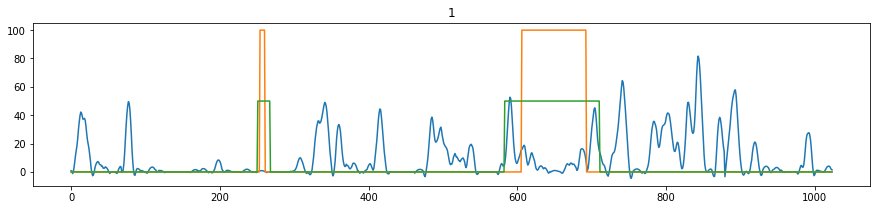

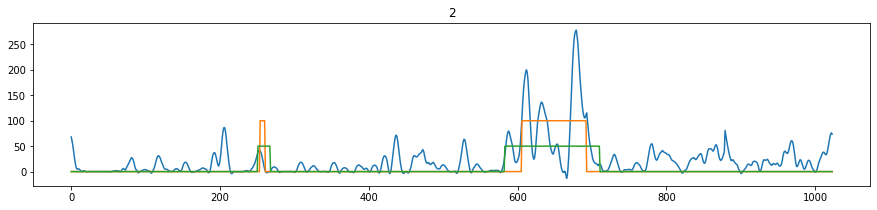

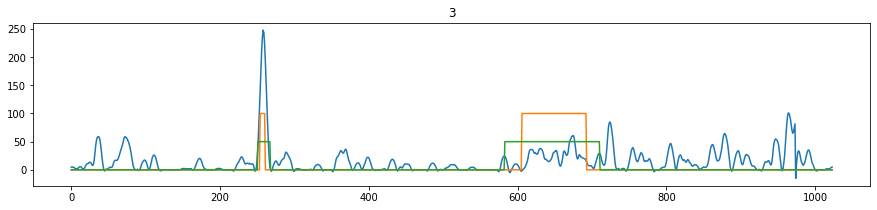

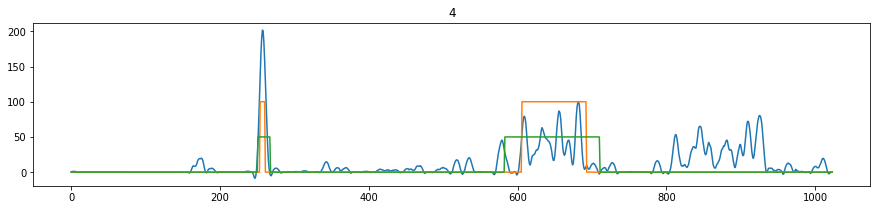

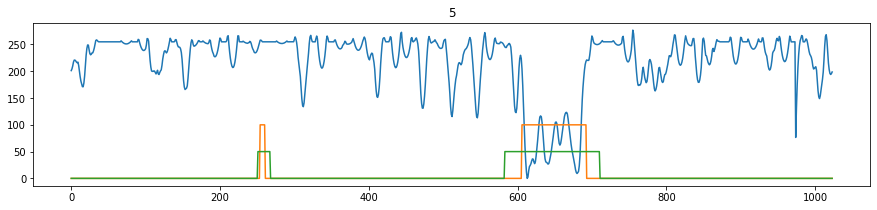

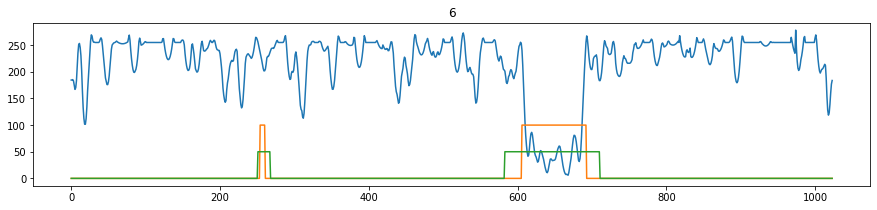

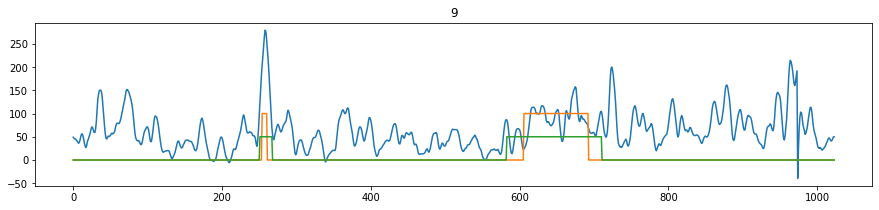

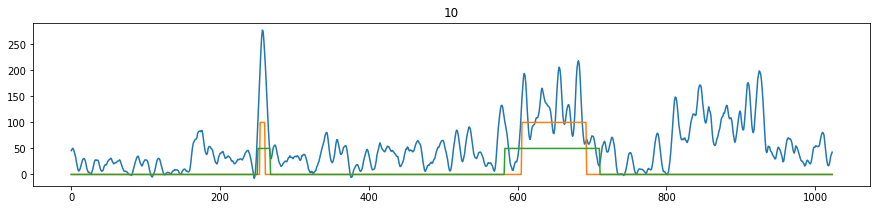

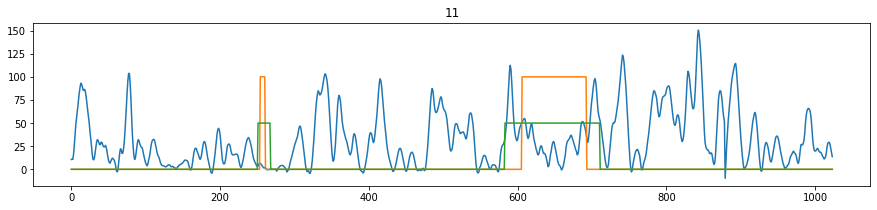

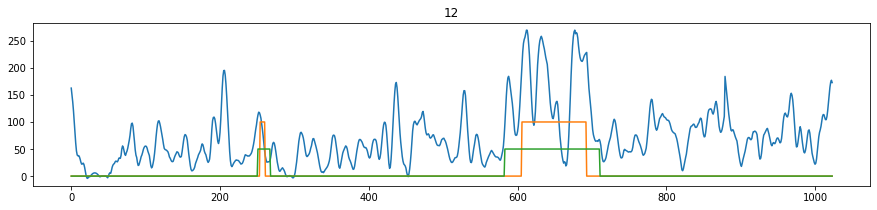

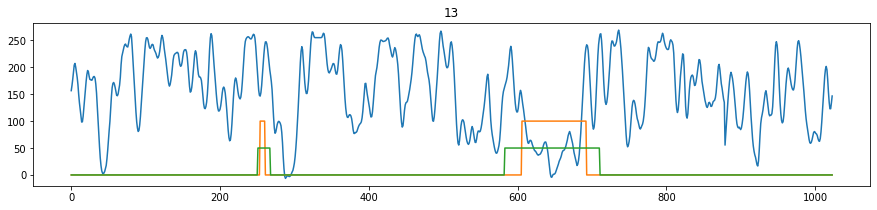

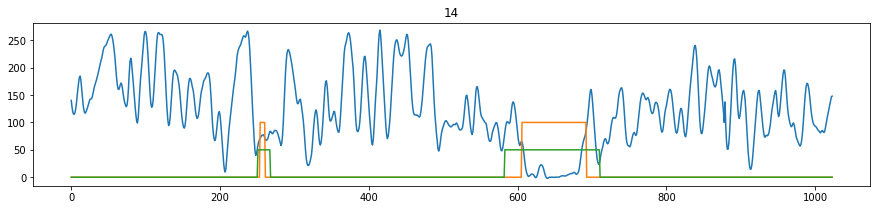

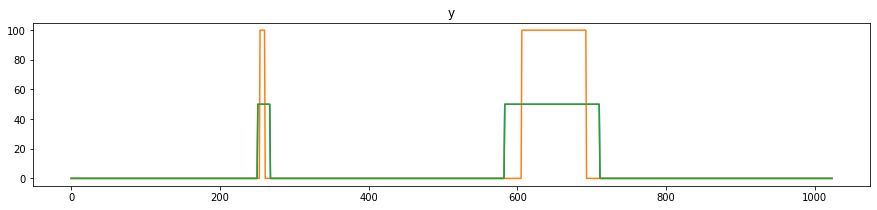

In [125]:
display_values(sop.longitudinal_defects_set)

In [96]:
plt.figure(figsize=(20,10))
plt.plot(T_train_prediction[:1024])
plt.plot()
plt.show()


NameError: name 'T_train_prediction' is not defined

<Figure size 1440x720 with 0 Axes>

# Продольный 

ValueError: x and y can be no greater than 2-D, but have shapes (0,) and (0, 1024, 1)

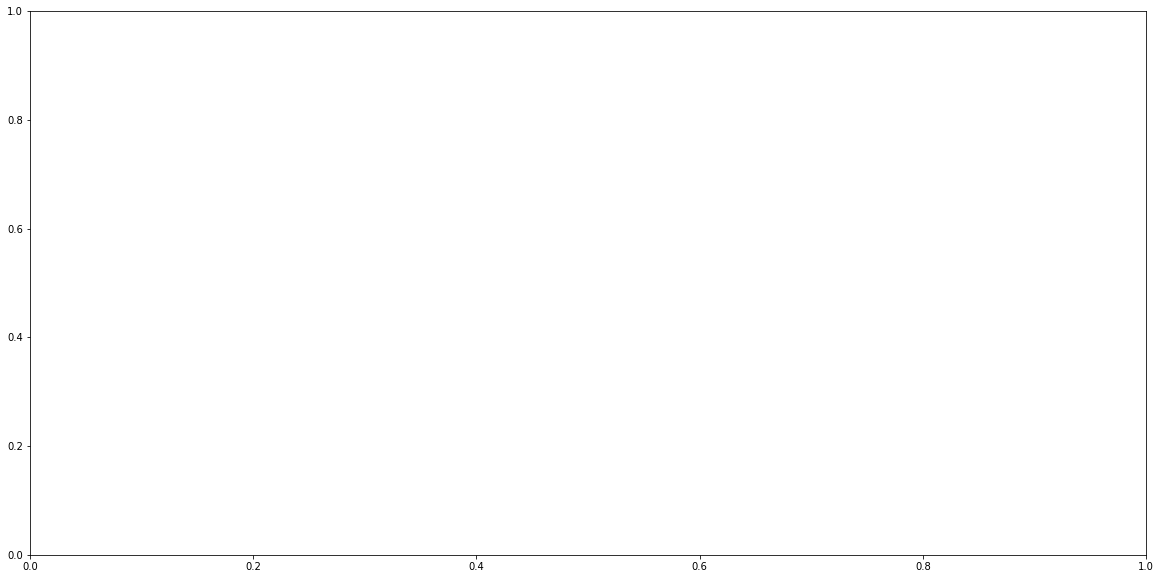

In [97]:
plt.figure(figsize=(20,10))
plt.plot(train_prediction[2048:])
plt.show()

Вместо таблицы с целевыми переменными расмотрим график показывающий предсказания каждой из моеделей, если визуально посмотреть в таблицу каждого сигнала (онми здесь расположены в одной линии), то можно увидеть что координаты дефектов на графике примерно совпадают с коррдинатами в таблице

In [189]:
model_longitudinal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1024, 64)          11520     
_________________________________________________________________
gru_1 (GRU)                  (None, 1024, 1)           198       
Total params: 11,718
Trainable params: 11,718
Non-trainable params: 0
_________________________________________________________________
